### 외부 종속성

In [79]:
#device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
#device

In [2]:
# print (torch.__version__)
# print(torch.backends.mps.is_built())
# print(torch.backends.mps.is_available())

In [1]:
import torch

import torchvision
from torchvision import datasets
from torchvision import transforms

from torch.utils.data import DataLoader
from torch.utils.data import random_split

import numpy as np
import matplotlib.pyplot as plt

import cv2
from copy import deepcopy

### Kaggle에서 데이터 받아오기

In [2]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"calebsuminkim","key":"17b9d5f303937ab148df1f68d2c0f2af"}'}

In [3]:
# permission warning 방지
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# download
!kaggle datasets download -d ammaralfaifi/5class-weather-status-image-classification

# unzip
!unzip -q 5class-weather-status-image-classification.zip -d weather/

 97% 485M/498M [00:02<00:00, 240MB/s]
100% 498M/498M [00:02<00:00, 230MB/s]


In [4]:
data_dir = './weather'

In [5]:
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor()
])

In [6]:
dataset = datasets.ImageFolder(root = data_dir + '/data', transform = transform)

In [7]:
dataset

Dataset ImageFolder
    Number of datapoints: 18038
    Root location: ./weather/data
    StandardTransform
Transform: Compose(
               Resize(size=[224, 224], interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [36]:
18038 * 0.8

14430.400000000001

In [37]:
# train set
18038 * 0.8 * 0.8

11544.320000000002

In [38]:
# valid set
18038 * 0.8 * 0.2

2886.0800000000004

In [39]:
# test set
18038 * 0.2

3607.6000000000004

In [40]:
18038 * 0.8 * 0.8 + 18038 * 0.8 * 0.2 + 18038 * 0.2

18038.0

In [41]:
11544 + 2886 + 3607

18037

In [8]:
trainset, validset, testset = random_split(dataset, [11544, 2886, 3608])

In [9]:
type(trainset), len(trainset) # torch.utils.data.dataset.Subset

(torch.utils.data.dataset.Subset, 11544)

In [10]:
type(validset), len(validset)

(torch.utils.data.dataset.Subset, 2886)

In [11]:
type(testset), len(testset)

(torch.utils.data.dataset.Subset, 3608)

In [12]:
for i in range(30):
    print(trainset[i])

(tensor([[[0.8784, 0.8784, 0.8784,  ..., 0.9255, 0.9255, 0.9255],
         [0.8784, 0.8784, 0.8784,  ..., 0.9255, 0.9255, 0.9255],
         [0.8784, 0.8784, 0.8784,  ..., 0.9216, 0.9216, 0.9216],
         ...,
         [0.4000, 0.4078, 0.4196,  ..., 0.5255, 0.5294, 0.5255],
         [0.4196, 0.4039, 0.3882,  ..., 0.4902, 0.4784, 0.4627],
         [0.4157, 0.3922, 0.3647,  ..., 0.4118, 0.3961, 0.3843]],

        [[0.8784, 0.8784, 0.8784,  ..., 0.9255, 0.9255, 0.9255],
         [0.8784, 0.8784, 0.8784,  ..., 0.9255, 0.9255, 0.9255],
         [0.8784, 0.8784, 0.8784,  ..., 0.9216, 0.9216, 0.9216],
         ...,
         [0.4000, 0.4078, 0.4196,  ..., 0.5294, 0.5333, 0.5255],
         [0.4196, 0.4039, 0.3882,  ..., 0.4941, 0.4824, 0.4627],
         [0.4157, 0.3922, 0.3647,  ..., 0.4157, 0.3961, 0.3843]],

        [[0.8784, 0.8784, 0.8784,  ..., 0.9255, 0.9255, 0.9255],
         [0.8784, 0.8784, 0.8784,  ..., 0.9255, 0.9255, 0.9255],
         [0.8784, 0.8784, 0.8784,  ..., 0.9216, 0.9216, 0

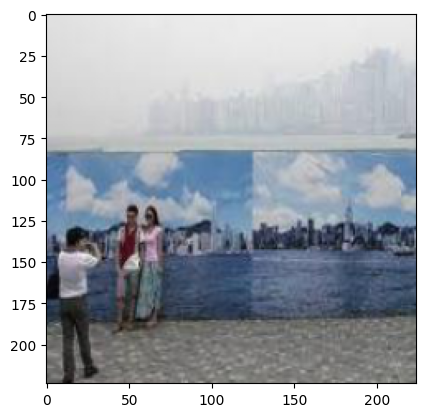

In [13]:
plt.imshow(trainset[0][0].permute(1, 2, 0))

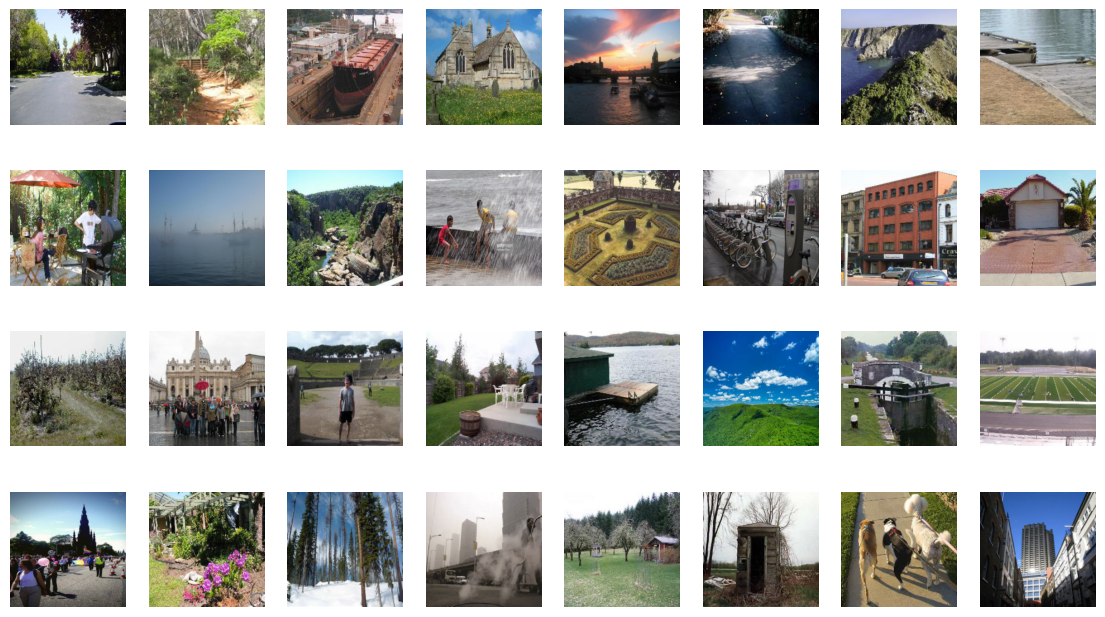

In [14]:
figure, axes = plt.subplots(nrows = 4, ncols = 8, figsize = (14, 8))
axes = axes.flatten()

for i in range(32):
    rand_i = np.random.randint(0, len(trainset))
    axes[i].imshow(trainset[rand_i][0].permute(1, 2, 0))

    axes[i].axis('off')

In [15]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### 모델 불러오기

In [16]:
import torchvision.models as models

# https://github.com/pytorch/vision/tree/6db1569c89094cf23f3bc41f79275c45e9fcb3f3/torchvision/models

model = models.alexnet(weights = True) # 모델 아키텍처 가져오기기
model

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 131MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [17]:
for parameter in model.parameters():
    parameter.requires_grad = False

for parameter in model.classifier.parameters():
    parameter.requires_grad = True

In [18]:
model.classifier = nn.Sequential(
    nn.Linear(in_features = 9216, out_features = 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(p=0.5, inplace = False),
    nn.Linear(in_features = 4096, out_features = 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Linear(in_features = 2048, out_features = 5, bias = True)
)

In [19]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dro

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [21]:
model.to(device)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dro

### 모델 컴파일

In [22]:
learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = learning_rate)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.1, patience = 4, verbose = True)

In [23]:
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

In [24]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [25]:
batch_size = 16 # 100 -> 16
# dataloader = DataLoader(데이터셋, 배치사이즈, 셔플여부.....)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True) # 훈련용 50000개의 데이터를 100개씩 준비
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False) # 검증용 10000개의 데이터를 100개씩 준비
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False) # 테스트용 10000개의 데이터를 100개씩 준비

### 모델 훈련

In [26]:
def validate(model, validloader, loss_fn):
  total = 0   
  correct = 0
  valid_loss = 0
  valid_accuracy = 0

  # 전방향 예측을 구할 때는 gradient가 필요가 없음
  with torch.no_grad():
    for images, labels in validloader: # 이터레이터로부터 next()가 호출되며 미니배치 100개씩을 반환(images, labels)      
      # images, labels : (torch.Size([16, 3, 32, 32]), torch.Size([16]))
      # 0. Data를 GPU로 보내기
      images, labels = images.to(device), labels.to(device)

      # 1. 입력 데이터 준비
      # not Flatten !!
      # images.resize_(images.size()[0], 784)

      # 2. 전방향(Forward) 예측
      logit = model(images) # 예측 점수
      _, preds = torch.max(logit, 1) # 배치에 대한 최종 예측
      # preds = logit.max(dim=1)[1] 
      correct += int((preds == labels).sum()) # 배치 중 맞은 것의 개수가 correct에 누적
      total += labels.shape[0] # 배치 사이즈만큼씩 total에 누적

      loss = loss_fn(logit, labels)
      valid_loss += loss.item() # tensor에서 값을 꺼내와서, 배치의 loss 평균값을 valid_loss에 누적

    valid_accuracy = correct / total
  
  return valid_loss, valid_accuracy

In [27]:
writer = SummaryWriter()

def train_loop(model, trainloader, loss_fn, epochs, optimizer):  
  steps = 0
  steps_per_epoch = len(trainloader) 
  min_loss = 1000000
  max_accuracy = 0
  trigger = 0
  patience = 7 

  trainloss_l = []
  validloss_l = []
  validaccuracy_l = []
  for epoch in range(epochs):
    model.train() # 훈련 모드
    train_loss = 0
    for images, labels in trainloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)
      steps += 1
      # images, labels : (torch.Size([16, 3, 32, 32]), torch.Size([16]))
      # 0. Data를 GPU로 보내기
      images, labels = images.to(device), labels.to(device)

      # 1. 입력 데이터 준비
      # not Flatten !!
      # images.resize_(images.shape[0], 784) 

      # 2. 전방향(forward) 예측
      predict = model(images) # 예측 점수
      loss = loss_fn(predict, labels) # 예측 점수와 정답을 CrossEntropyLoss에 넣어 Loss값 반환

      # 3. 역방향(backward) 오차(Gradient) 전파
      optimizer.zero_grad() # Gradient가 누적되지 않게 하기 위해
      loss.backward() # 모델파리미터들의 Gradient 전파

      # 4. 경사 하강법으로 모델 파라미터 업데이트
      optimizer.step() # W <- W -lr*Gradient

      train_loss += loss.item()
      if (steps % steps_per_epoch) == 0 : 
        model.eval() # 평가 모드 : 평가에서 사용하지 않을 계층(배치 정규화, 드롭아웃)들을 수행하지 않게 하기 위해서
        valid_loss, valid_accuracy = validate(model, validloader, loss_fn)

        # tensorboard 시각화를 위한 로그 이벤트 등록
        writer.add_scalar('Train Loss', train_loss/len(trainloader), epoch+1)
        writer.add_scalar('Valid Loss', valid_loss/len(validloader), epoch+1)
        writer.add_scalars('Train Loss and Valid Loss',
                          {'Train' : train_loss/len(trainloader),
                            'Valid' : valid_loss/len(validloader)}, epoch+1)
        writer.add_scalar('Valid Accuracy', valid_accuracy, epoch+1)

        # -------------------------------------------

        print('Epoch : {}/{}.......'.format(epoch+1, epochs),            
              'Train Loss : {:.3f}'.format(train_loss/len(trainloader)), 
              trainloss_l.append(train_loss / len(trainloader)),
              'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)), 
              validloss_l.append(valid_loss/len(validloader)),
              'Valid Accuracy : {:.3f}'.format(valid_accuracy),
              validaccuracy_l.append(valid_accuracy)
              )
        
        # Best model 저장    
        # option 1 : valid_loss 모니터링
        # if valid_loss < min_loss: # 바로 이전 epoch의 loss보다 작으면 저장하기
        #   min_loss = valid_loss
        #   best_model_state = deepcopy(model.state_dict())          
        #   torch.save(best_model_state, 'best_checkpoint.pth')     
        
        # option 2 : valid_accuracy 모니터링      
        if valid_accuracy > max_accuracy : # 바로 이전 epoch의 accuracy보다 크면 저장하기
          max_accuracy = valid_accuracy
          best_model_state = deepcopy(model.state_dict())          
          torch.save(best_model_state, 'best_checkpoint.pth')  
        # -------------------------------------------

        # Early Stopping (조기 종료)
        if valid_loss > min_loss: # valid_loss가 min_loss를 갱신하지 못하면
          trigger += 1
          print('trigger : ', trigger)
          if trigger > patience:
            print('Early Stopping !!!')
            print('Training loop is finished !!')
            writer.flush()   
            return
        else:
          trigger = 0
          min_loss = valid_loss
        # -------------------------------------------

        # Learning Rate Scheduler
        scheduler.step(valid_loss)
        # -------------------------------------------
        
  writer.flush()
  return  

In [ ]:
epochs = 55
train_loop(model, trainloader, loss_fn, epochs, optimizer)
writer.close()

Epoch : 1/55....... Train Loss : 1.060 None Valid Loss : 0.795 None Valid Accuracy : 0.690 None
Epoch : 2/55....... Train Loss : 0.788 None Valid Loss : 0.725 None Valid Accuracy : 0.740 None
Epoch : 3/55....... Train Loss : 0.698 None Valid Loss : 0.668 None Valid Accuracy : 0.762 None
Epoch : 4/55....... Train Loss : 0.638 None Valid Loss : 0.701 None Valid Accuracy : 0.737 None
trigger :  1
Epoch : 5/55....... Train Loss : 0.576 None Valid Loss : 0.625 None Valid Accuracy : 0.768 None
Epoch : 6/55....... Train Loss : 0.539 None Valid Loss : 0.629 None Valid Accuracy : 0.772 None
trigger :  1
Epoch : 7/55....... Train Loss : 0.508 None Valid Loss : 0.638 None Valid Accuracy : 0.767 None
trigger :  2
Epoch : 8/55....... Train Loss : 0.466 None Valid Loss : 0.632 None Valid Accuracy : 0.773 None
trigger :  3




ㄴ-----------------------4월 14일------------------------

